<a href="https://colab.research.google.com/github/oshodiS/AII/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

# 0. Importing libraries

In [23]:
%%capture
!pip install fitter
!pip install pydot
!pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from fitter import Fitter
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks

# 1. Load and inspect the dataset

In [3]:
# se con colab
from pathlib import Path

from google.colab import drive

drive.mount('/content/drive')
data_folder = Path.cwd() / "drive" / "MyDrive" / "A3I" / "data"
dataset_path = data_folder.joinpath("AMS_descritt_noSM_meltD_adim.csv")

# se in locale
#dataset_path = "data/AMS_descritt_noSM_meltD_adim.csv"

df = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df.drop(df.columns[[0]], axis=1, inplace=True)
df.head()

Mounted at /content/drive


,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


In [4]:
df.columns

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')

In [5]:
# Unique duration values

DURATION = df['duration[h]'].unique()
print(DURATION)

[ 1  3  6 12 24]


## 1.1. Preprocess the dataset
spiegazione

In [6]:
# create a dictionary of dataframes, one for each duration
dfs = {}
for duration in DURATION:
    dfs[f'{duration}'] = df[df['duration[h]'] == duration].drop("duration[h]", axis=1, inplace=False)
    dfs[f'{duration}'].reset_index(drop=True, inplace=True)


In [7]:
dfs['3']

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,VarClimSowP(mm),X,Y,AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,1.106796,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.893204,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
2,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,1.184466,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
3,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.815534,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,23.933985,555576.92,4921743.21,0.876011,53.195652,0.783417,0.300108,2.163958,1.674796,1.233560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.946180,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54924,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,1.009611,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54925,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.459875,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54926,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,1.009611,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428


In [8]:
# maximum value of AMS in each dataframe
for duration in DURATION:
    print(f"maximum AMS in {duration}h: {dfs[f'{duration}']['AMS'].max()}")

maximum AMS in 1h: 4.782464297575557
maximum AMS in 3h: 4.905896003540713
maximum AMS in 6h: 5.373404747735238
maximum AMS in 12h: 5.915663202234329
maximum AMS in 24h: 6.288661312900612


In [9]:
def standardize_AMS(df, k = 1, IdD = True):
    """
        df: dataframe
        k: Multiplication factor to extend the range of AMS values. Defaults to 1.
        IdD: To specify how standardize. Defaults to True.

    """

    if IdD:
        df['AMS'] = df.apply(lambda row: row['AMS'] * row['IdD'], axis=1)

    min_AMS = df['AMS'].min()
    max_AMS = df['AMS'].max() * k

    df['AMS'] = df.apply(lambda row: (row['AMS'] - min_AMS) / (max_AMS - min_AMS), axis=1)

    return df


In [10]:
std_dfs = {}
for duration in DURATION:
    std_dfs[f'{duration}'] = standardize_AMS(dfs[f'{duration}'], IdD = False)

In [11]:
std_dfs['3']

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,VarClimSowP(mm),X,Y,AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.223188,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.179515,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
2,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.239070,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
3,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,281.338470,633069.81,4890553.68,0.163633,51.500000,0.925308,0.129267,1.519957,1.309257,1.119201
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,23.933985,555576.92,4921743.21,0.175999,53.195652,0.783417,0.300108,2.163958,1.674796,1.233560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54923,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.190347,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54924,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.203317,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54925,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.090911,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428
54926,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,10.285090,696822.00,5044294.00,0.203317,37.836364,0.869541,0.265935,2.092882,1.659420,1.268428


In [13]:
# colab
dataset_path = data_folder.joinpath("gumMap_statbench_Gumfit_NEW.csv")

#  locale
#dataset_path = "data/gumMap_statbench_Gumfit_NEW.csv"

df2 = pd.read_csv(dataset_path, sep=',', encoding='utf-8')
df2.head()

,Unnamed: 0,ID,Nome,md_1h,md_3h,md_6h,md_12h,md_24h,q1h_0.80,q1h_0.95,...,q_3h_0.99,q_6h_0.80,q_6h_0.95,q_6h_0.99,q_12h_0.80,q_12h_0.95,q_12h_0.99,q_24h_0.80,q_24h_0.95,q_24h_0.99
0,0,5005,'Anzola_Dellemilia',1.0,1.0,1.0,1.0,1.0,1.297268,1.770921,...,2.204652,1.262136,1.679814,2.142859,1.256130,1.664236,2.116671,1.257223,1.667072,2.121439
1,1,5007,'Argelato',1.0,1.0,1.0,1.0,1.0,1.307714,1.798013,...,2.270210,1.272879,1.707674,2.189696,1.264559,1.686097,2.153422,1.257970,1.669008,2.124694
2,2,5015,'Bardi_Centrale',1.0,1.0,1.0,1.0,1.0,1.271656,1.704500,...,2.174044,1.257236,1.667106,2.121495,1.251259,1.651604,2.095435,1.253316,1.656940,2.104405
3,3,5141,'Invaso',1.0,1.0,1.0,1.0,1.0,1.271679,1.704561,...,2.174045,1.257236,1.667106,2.121496,1.251259,1.651605,2.095436,1.253324,1.656960,2.104438
4,4,5143,'Isola_Di_Palanzano_Centrale',1.0,1.0,1.0,1.0,1.0,1.265930,1.689653,...,2.173967,1.257225,1.667077,2.121446,1.251233,1.651538,2.095324,1.250087,1.648565,2.090326


## 1.2. Train-Val-Test split

In [14]:
# Take the first 100 ID from df2 and use them to create the test sets
test_ID = df2['ID'].to_list()[:100]

test_dfs = {}
for duration in DURATION:
    test_dfs[f'{duration}'] = std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)]
    test_dfs[f'{duration}'].reset_index(drop=True, inplace=True)


In [15]:
# Drop the test set from std_dfs and then create the train sets and validation sets
for duration in DURATION:
    std_dfs[f'{duration}'] = std_dfs[f'{duration}'].drop(std_dfs[f'{duration}'][std_dfs[f'{duration}']['ID'].isin(test_ID)].index,)
    std_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

validation_split = 0.1

train_dfs = {}
val_dfs = {}
for duration in DURATION:
    train_dfs[f'{duration}'], val_dfs[f'{duration}'] = train_test_split(std_dfs[f'{duration}'], test_size=validation_split, random_state=42)
    train_dfs[f'{duration}'].reset_index(drop=True, inplace=True)
    val_dfs[f'{duration}'].reset_index(drop=True, inplace=True)

In [16]:
train_dfs['3']

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,VarClimSowP(mm),X,Y,AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,9162,'Lecco_Via_Sora',282.547531,49.481426,7.358590,6.876921,204.597871,41.207173,235.482223,461.481440,...,10.050817,531071.00,5078912.00,0.278673,48.035294,0.843829,0.293843,2.195550,1.716600,1.284576
1,12389,'Carcoforo',1503.434625,153.863643,29.326207,12.711749,176.098867,88.626781,338.975030,332.438539,...,234.865265,426444.00,5084376.00,0.292481,50.495263,0.836012,0.285218,2.148055,1.683164,1.263821
2,5126,'Forli',28.513426,2.609342,0.435942,0.285487,118.752622,89.483449,24.737697,12.379064,...,5.954321,744076.21,4900690.26,0.082840,33.301205,0.825165,0.282329,2.123920,1.663737,1.248642
3,5276,'San_Benedetto_In_Alpe',619.586770,90.153743,19.262117,8.199261,168.916188,92.213715,61.828073,249.049105,...,28.295330,715463.62,4873693.67,0.299571,36.477778,0.855167,0.238222,1.951023,1.562732,1.212486
4,16076,'Porrino',823.721317,109.442109,21.803450,7.504031,161.794434,82.870609,129.473226,386.339120,...,84.407043,639275.00,4885950.00,0.166370,49.462069,0.822165,0.304437,2.222620,1.726402,1.278802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46655,8072,'Colle_Del_Melogno',1017.392522,148.313182,20.703809,7.836887,164.489004,67.864609,325.281240,363.897139,...,68.329819,436307.14,4897988.10,0.075316,61.000000,0.787979,0.332043,2.315428,1.774213,1.286024
46656,18022,'Naturno_-_Naturns',611.608689,121.523971,13.241030,15.038922,132.092120,94.217896,173.771299,793.199256,...,9.533550,652371.00,5167937.00,0.131590,23.375000,0.852139,0.231423,1.916721,1.539511,1.199260
46657,16177,'Consuma',944.849158,56.226250,12.355154,5.672587,214.207579,109.720909,80.130591,444.802281,...,31.726362,708125.00,4851395.00,0.260061,39.623188,0.850712,0.270816,2.096508,1.655090,1.256920
46658,5031,'Bologna_Idrografico',56.358650,9.241380,1.418355,0.779833,162.085601,131.814673,73.991208,11.408480,...,9.792802,686515.48,4930073.52,0.140246,33.373494,0.834593,0.269108,2.072531,1.633897,1.238239


## 1.3. Dataset inspection

#### Timeseries length distribution for each duration, both for training and validation

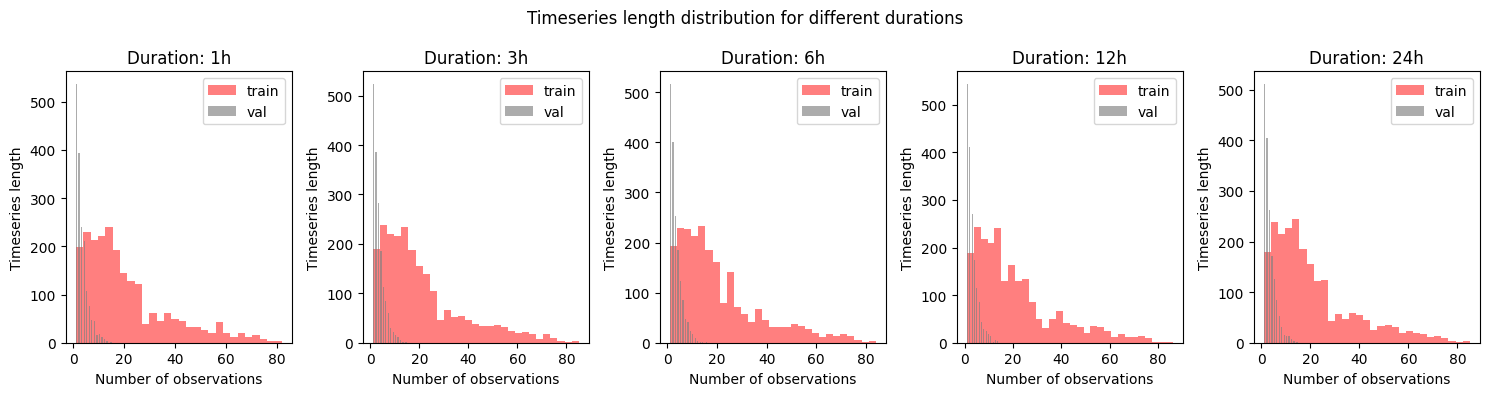

In [17]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))  # 1 row, 5 columns
fig.suptitle("Timeseries length distribution for different durations")

for i, duration in enumerate(DURATION):
    ax = axes[i]
    ax.hist(train_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.5, label='train', color='red')
    ax.hist(val_dfs[f'{duration}']['ID'].value_counts(), bins='auto', alpha=0.65, label='val', color='gray')
    ax.legend()
    ax.set_title(f"Duration: {duration}h")
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("Timeseries length")

plt.tight_layout()
plt.show()

### MAP distribution for training and validation

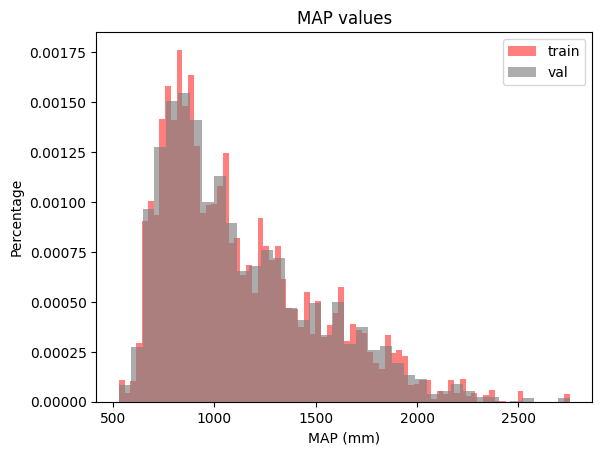

In [18]:
plt.hist(train_dfs['3']['MAP(mm)'], bins='auto', alpha=0.5, label='train', density=True, color='red')
plt.hist(val_dfs['3']['MAP(mm)'], bins='auto', alpha=0.65, label='val', density=True, color='gray')
plt.ylabel('Percentage')
plt.title('MAP values')
plt.xlabel('MAP (mm)')
plt.legend()
plt.show()

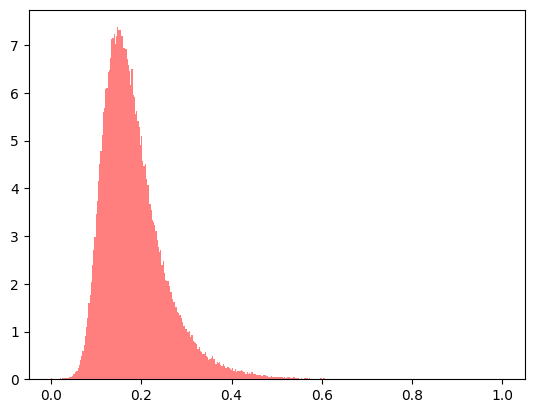

In [21]:
#create a global list of ams
ams_global =  list(chain.from_iterable([train_dfs[duration]['AMS'] for duration in train_dfs]))

#plot the histogram
plt.hist(ams_global, bins='auto', alpha=0.5, label='train', density=True, color='red');

2024-01-16 10:58:14.977 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=9.886283)
2024-01-16 10:58:15.043 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=48.137398)
2024-01-16 10:58:15.101 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted uniform distribution with error=382.485734)
2024-01-16 10:58:22.686 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=10.301203)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,9.886283,1305.815923,1336.895097,inf,0.041642,0.0
beta,10.301203,1286.075536,1327.514434,inf,0.042259,0.0
norm,48.137398,3111.762036,3132.481485,inf,0.091773,0.0
uniform,382.485734,4.000000,24.719449,inf,0.632520,0.0


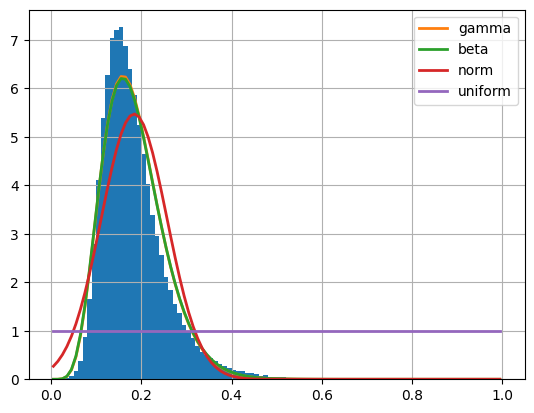

In [22]:
#Fit distribution
ams_global_np = np.array(ams_global)
f = Fitter(ams_global, distributions=['beta', 'gamma', 'norm', 'uniform'])
f.fit()
f.summary()

In [24]:
a_guess, b_guess, loc, scale  = f.fitted_param['beta']
print("alpha: ", a_guess)
print("beta: ", b_guess)

alpha:  7.344497374416402
beta:  1492966.2924921117


## prepare data for training

In [26]:
columns = train_dfs['1'].columns
input_columns = columns[2:-7]
output_column = 'AMS'
print('Input columns: ', input_columns)

Input columns:  Index(['HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [27]:
inputs_train = {}
outputs_train = {}
for duration in DURATION:
    inputs_train[f'{duration}'] = train_dfs[f'{duration}'][input_columns]
    outputs_train[f'{duration}'] = train_dfs[f'{duration}'][output_column]

inputs_val = {}
outputs_val = {}
for duration in DURATION:
    inputs_val[f'{duration}'] = val_dfs[f'{duration}'][input_columns]
    outputs_val[f'{duration}'] = val_dfs[f'{duration}'][output_column]


In [28]:
inputs_train['1']

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,679.993792,45.869814,13.264418,7.123736,170.571521,100.642219,144.220212,105.329868,181.191415,828.625305,59.172165,773.647466,423.515805,1826.318359,906.441528,19.353260,222.706787,24.241676,615045.34,4926696.71
1,401.542595,3.391480,0.987050,1.323965,209.704078,111.139742,353.694375,353.003761,342.688369,1619.006958,58.741392,541.599013,240.004022,1268.915039,737.554382,3.570877,214.809128,5.770571,403729.00,4932637.00
2,700.331139,87.197775,11.816385,5.900658,261.078250,69.458498,234.998491,300.161545,401.371543,1689.465698,25.544626,578.823683,317.588741,1228.365234,1579.362061,29.086729,411.523651,31.764061,522428.95,4935883.27
3,89.788087,69.164370,11.765645,7.959021,148.049637,58.924999,322.450049,345.412352,399.984410,1833.590088,0.932280,78.850413,69.155061,354.122467,874.710999,0.005686,264.372833,0.047235,441005.38,4888425.65
4,19.201906,11.016619,1.369560,1.165816,214.513901,89.143181,146.802101,250.378015,252.626286,1049.537109,30.911621,159.884625,239.256341,866.639832,1087.687988,0.060204,260.126312,0.500089,633430.00,4848365.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46660,1017.392522,148.313182,20.703809,7.836887,164.489004,67.864609,325.281240,363.897139,389.894169,1559.426758,11.363636,405.942161,338.527752,1316.266357,1173.831055,79.781853,392.248108,68.329819,436307.14,4897988.10
46661,611.608689,121.523971,13.241030,15.038922,132.092120,94.217896,173.771299,793.199256,696.396910,2551.066162,290.047545,1029.742294,898.857310,3516.026123,575.047974,8.776395,159.968369,9.533550,652371.00,5167937.00
46662,944.849158,56.226250,12.355154,5.672587,214.207579,109.720909,80.130591,444.802281,364.558877,1525.798828,103.136792,232.837327,190.820655,1065.446655,1256.661011,42.421860,276.064575,31.726362,708125.00,4851395.00
46663,56.358650,9.241380,1.418355,0.779833,162.085601,131.814673,73.991208,11.408480,16.116590,77.055939,111.670552,626.416980,453.472365,2146.471436,749.848816,5.297444,169.082825,9.792802,686515.48,4930073.52


In [ ]:
def build_nn_beta_model(input_shape, hidden, alpha_guess=1, beta_guess=1):
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    alpha_beta = layers.Dense(2, activation='linear')(x)
    lf = lambda t: tfp.distributions.Beta(concentration1=tf.math.exp(t[:, 0:1]) , concentration0=tf.math.exp(t[:, 1:2]) )
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

In [ ]:
def plot_nn_model(model):
    return keras.utils.plot_model(model, show_shapes=True,
            show_layer_names=True, rankdir='LR', show_layer_activations=True)

In [ ]:
def train_nn_model(model, X, y, loss, validation_data=None, verbose=True, patience=5, epochs=1, batch_size=1):
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-1), loss=loss)
    # Build the early stop callback
    cb = []
    if validation_data is not None:
        cb += [callbacks.EarlyStopping(patience=patience,restore_best_weights=True)]
    # Train the model
    history = model.fit(X, y, callbacks=cb,
            validation_data=validation_data,
            verbose=verbose, epochs=epochs, batch_size=batch_size)
    return history

In [ ]:
def plot_training_history(history=None,
        figsize=None, print_final_scores=True):
    plt.figure(figsize=figsize)
    for metric in history.history.keys():
        plt.plot(history.history[metric], label=metric)
    # if 'val_loss' in history.history.keys():
    #     plt.plot(history.history['val_loss'], label='val. loss')
    if len(history.history.keys()) > 0:
        plt.legend()
    plt.xlabel('epochs')
    plt.grid(linestyle=':')
    plt.tight_layout()
    plt.show()
    if print_final_scores:
        trl = history.history["loss"][-1]
        s = f'Final loss: {trl:.4f} (training)'
        if 'val_loss' in history.history:
            vll = history.history["val_loss"][-1]
            s += f', {vll:.4f} (validation)'
        print(s)

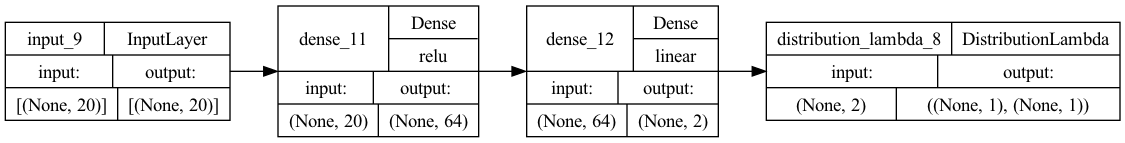

In [ ]:
nnb = build_nn_beta_model(input_shape=len(input_columns), hidden=[64,], alpha_guess=a, beta_guess=b)
plot_nn_model(nnb)

In [ ]:
negloglikelihood = lambda y_true, dist: -dist.log_prob(y_true)

history = train_nn_model(nnb, inputs_train['1'], outputs_train['1'], validation_data=(inputs_val['1'],outputs_val['1']),loss=negloglikelihood, batch_size=16, epochs=10)
plot_training_history(history, figsize=(9, 3))